In [1]:
# Import libraries
#import torch
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import logging
from tqdm.notebook import tqdm  # Use notebook-specific tqdm for single-line updates


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load the NetCDF file
nc_file1 = "/content/drive/MyDrive/ERA5_datasets/data_accum.nc"
nc_file2 = "/content/drive/MyDrive/ERA5_datasets/data_instant.nc"
ds1 = xr.open_dataset(nc_file1)
ds2 = xr.open_dataset(nc_file2)

ds = xr.merge([ds1, ds2], compat='override')
# Print dataset details
print(ds)

# Select variables
#variables = ['tp', 't2m', 'd2m', 'u10', 'v10', 'msl', 'tcwv', 'cape', 'slhf', 'sshf']
#data_arrays = [ds[var].values for var in variables]

# Stack variables into tensor [time, lat, lon, channels]
#data = np.stack(data_arrays, axis=-1)  # Shape: [hours, lat, lon, 10]



<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2160, latitude: 105, longitude: 237)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 17kB 2025-01-01 ... 2025-03-31T23...
  * latitude    (latitude) float64 840B 50.0 49.75 49.5 ... 24.5 24.25 24.0
  * longitude   (longitude) float64 2kB -125.0 -124.8 -124.5 ... -66.25 -66.0
    expver      (valid_time) <U4 35kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 215MB ...
    slhf        (valid_time, latitude, longitude) float32 215MB ...
    sshf        (valid_time, latitude, longitude) float32 215MB ...
    u10         (valid_time, latitude, longitude) float32 215MB ...
    v10         (valid_time, latitude, longitude) float32 215MB ...
    d2m         (valid_time, latitude, longitude) float32 215MB ...
    t2m         (valid_time, latitude, longitude) float32 215MB ...
    msl         (valid_time, latitude, longitude) float32 215MB ...
    tcwv        (valid_time,

In [3]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 66.5 MB/s eta 0:00:00


In [5]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import os
import pandas as pd
import matplotlib.ticker as mticker


Longitude shape: (237,), range: -125.00 to -66.00
Latitude shape: (105,), range: 24.00 to 50.00
Valid_time dimension: (2160,), values: ['2025-01-01T00:00:00.000000000' '2025-01-01T01:00:00.000000000'
 '2025-01-01T02:00:00.000000000' '2025-01-01T03:00:00.000000000'
 '2025-01-01T04:00:00.000000000']
Selected time step: index=744, date=2025-02-01 00:00:00
Total Precipitation shape: (105, 237), range: 0.00 to 6.83 mm
T2M shape: (105, 237), range: -25.94 to 27.62 °C


/usr/local/lib/python3.11/dist-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)
<ipython-input-7-d0bf6ba54186>:85: UserWarning: AutoMinorLocator does not work on logarithmic scales
  plt.savefig(os.path.join(output_dir, f'total_precipitation_march1_{target_date.strftime("%Y%m%d_%H%M")}.png'))
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.canvas.print_figure(bytes_io, **kw)


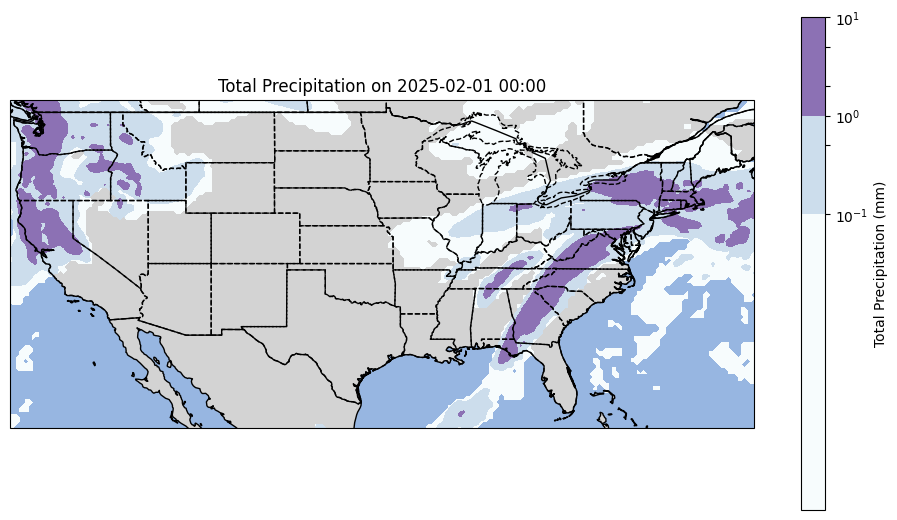

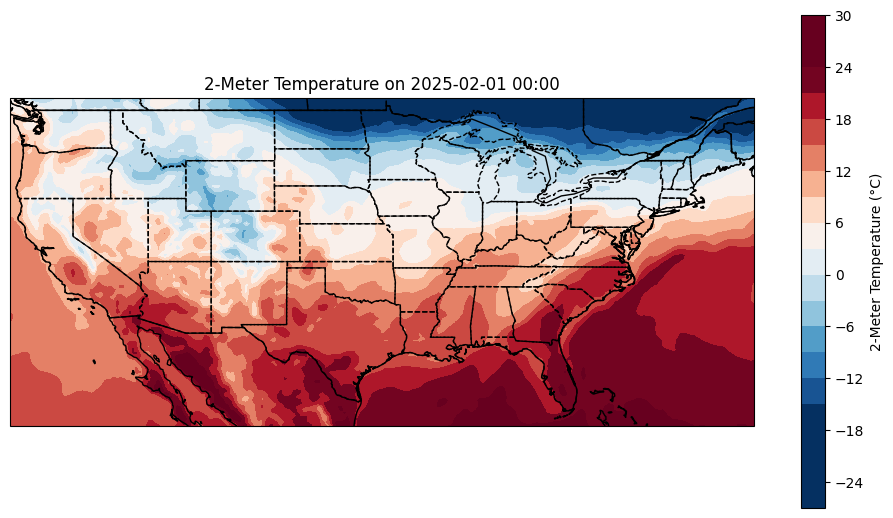

In [7]:


# Extract latitude and longitude
lat = ds.latitude.values  # Shape: (105,)
lon = ds.longitude.values  # Shape: (237,)
print(f"Longitude shape: {lon.shape}, range: {lon.min():.2f} to {lon.max():.2f}")
print(f"Latitude shape: {lat.shape}, range: {lat.min():.2f} to {lat.max():.2f}")

# Create meshgrid for contour plotting
lon_grid, lat_grid = np.meshgrid(lon, lat)  # Shapes: (105, 237)

# Inspect valid_time dimension
print(f"Valid_time dimension: {ds.valid_time.shape}, values: {ds.valid_time.values[:5]}")

# Select time step for March 1st, 2025 (using valid_time)
target_date = None
time_idx = None
for i, t in enumerate(ds.valid_time.values):
    dt = pd.Timestamp(t)  # Convert datetime64 to pandas Timestamp
    if dt.year == 2025 and dt.month == 2 and dt.day == 1 and dt.hour == 0:  # Match 00:00
        target_date = dt
        time_idx = i
        break

if time_idx is None:
    print("Warning: No exact March 1st, 2025 00:00 found. Selecting first March time step.")
    for i, t in enumerate(ds.valid_time.values):
        dt = pd.Timestamp(t)
        if dt.year == 2025 and dt.month == 3:
            target_date = dt
            time_idx = i
            break

if time_idx is None:
    print("Error: No March 2025 data found. Using time_idx=0 as fallback.")
    time_idx = 0
    target_date = pd.Timestamp(ds.valid_time.values[0])

print(f"Selected time step: index={time_idx}, date={target_date}")

# Extract total precipitation (tp)
total_precip = ds['tp'].isel(valid_time=time_idx).values  # Shape: (105, 237)
# Check units and convert to mm if needed
precip_units = ds['tp'].attrs.get('units', 'unknown')
if precip_units == 'm':
    total_precip = total_precip * 1000  # Convert meters to mm
elif precip_units != 'mm':
    print(f"Warning: Unknown precipitation units '{precip_units}', assuming meters")
    total_precip = total_precip * 1000

# Extract 2-meter temperature (t2m)
t2m = ds['t2m'].isel(valid_time=time_idx).values  # Shape: (105, 237)
# Check units and convert to °C if needed
t2m_units = ds['t2m'].attrs.get('units', 'unknown')
if t2m_units == 'K':
    t2m = t2m - 273.15  # Convert Kelvin to °C
elif t2m_units != 'C':
    print(f"Warning: Unknown t2m units '{t2m_units}', assuming Kelvin")
    t2m = t2m - 273.15

print(f"Total Precipitation shape: {total_precip.shape}, range: {total_precip.min():.2f} to {total_precip.max():.2f} mm")
print(f"T2M shape: {t2m.shape}, range: {t2m.min():.2f} to {t2m.max():.2f} °C")

# Create output directory
output_dir = "/content/drive/MyDrive/ERA5_datasets/visualizations"
os.makedirs(output_dir, exist_ok=True)

# Visualization 1: Total Precipitation (Improved Colormap)
fig1 = plt.figure(figsize=(12, 8))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES, linestyle='--')

# Plot total precipitation as filled contours with improved colormap
precip_cmap = plt.cm.BuPu  # Blue to purple for high contrast
precip_norm = mcolors.LogNorm(vmin=0.1, vmax=30)  # Log scale for skewed precipitation
cf1 = ax1.contourf(lon_grid, lat_grid, total_precip, cmap=precip_cmap, norm=precip_norm,
                   levels=30, transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf1, ax=ax1, label='Total Precipitation (mm)', shrink=0.8,
                    ticks=[0.1, 0.5, 1, 2, 5, 10, 15, 20, 25, 30])
cbar.ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
plt.title(f'Total Precipitation on {target_date.strftime("%Y-%m-%d %H:%M")}')
plt.savefig(os.path.join(output_dir, f'total_precipitation_march1_{target_date.strftime("%Y%m%d_%H%M")}.png'))
plt.show()

# Visualization 2: 2-Meter Temperature (t2m) (Unchanged)
fig2 = plt.figure(figsize=(12, 8))
ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.STATES, linestyle='--')

# Plot t2m as filled contours
t2m_cmap = plt.cm.RdBu_r
t2m_norm = mcolors.Normalize(vmin=np.percentile(t2m, 5), vmax=np.percentile(t2m, 95))  # 5th to 95th percentiles
cf2 = ax2.contourf(lon_grid, lat_grid, t2m, cmap=t2m_cmap, norm=t2m_norm,
                   levels=20, transform=ccrs.PlateCarree())
plt.colorbar(cf2, ax=ax2, label='2-Meter Temperature (°C)', shrink=0.8)

plt.title(f'2-Meter Temperature on {target_date.strftime("%Y-%m-%d %H:%M")}')
plt.savefig(os.path.join(output_dir, f't2m_march1_{target_date.strftime("%Y%m%d_%H%M")}.png'))
plt.show()